In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Load the cats vs dogs dataset
(train_ds, validation_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [12]:
# Print information about the dataset
print('Dataset info:')
print(f'Number of training examples: {info.splits["train"].num_examples}')
print('\nFeatures:')
print(info.features)

Dataset info:
Number of training examples: 23262

Features:
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})


In [13]:
# Data preprocessing
IMG_SIZE = 160

def preprocess(image, label):
    # Resize the image
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize pixel values
    image = image / 255.0
    return image, label

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Apply preprocessing to both datasets
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

# Configure datasets for performance
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_ds = validation_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [14]:
# Create the CNN model
model = tf.keras.Sequential([
    # First convolutional block
    tf.keras.layers.Conv2D(8, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(),
    
    # Second convolutional block
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Third convolutional block
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification (cat or dog)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 158, 158, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 79, 79, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 77, 77, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 38, 38, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 36, 36, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       331,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,873 (1.29 MB)

 Trainable params: 337,873 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - accuracy: 0.6174 - loss: 0.6433 - val_accuracy: 0.7405 - val_loss: 0.5283
Epoch 2/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.7381 - loss: 0.5341 - val_accuracy: 0.7618 - val_loss: 0.4948
Epoch 3/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7777 - loss: 0.4699 - val_accuracy: 0.7994 - val_loss: 0.4344
Epoch 4/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.8031 - loss: 0.4305 - val_accuracy: 0.8108 - val_loss: 0.4155
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.8259 - loss: 0.3967 - val_accuracy: 0.8102 - val_loss: 0.4243
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.8423 - loss: 0.3650 - val_accuracy: 0.8074 - val_loss: 0.4316
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.8539 - loss: 0.3363 - val_accuracy: 0.8194 - val_loss: 0.4227
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.8617 - loss: 0.3129 - 

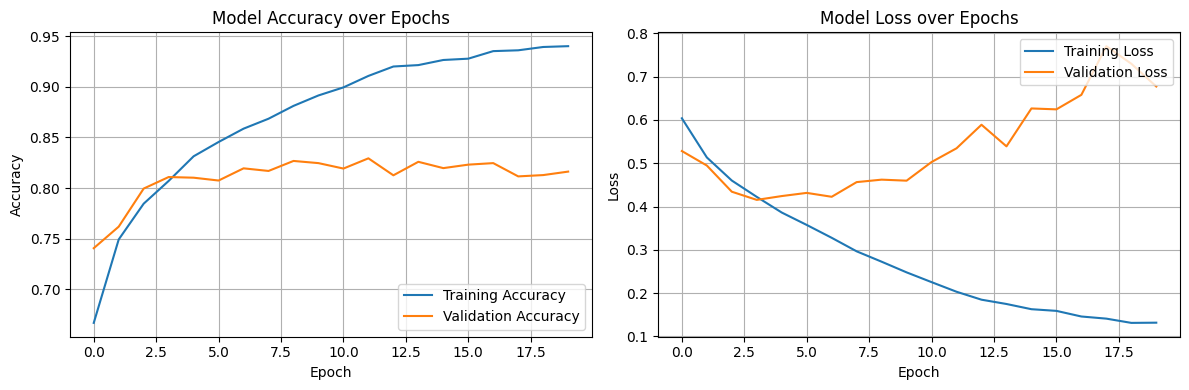


Final Training Metrics:
Training Accuracy: 0.9401
Validation Accuracy: 0.8162
Training Loss: 0.1319
Validation Loss: 0.6774


In [16]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print('\nFinal Training Metrics:')
print(f'Training Accuracy: {history.history["accuracy"][-1]:.4f}')
print(f'Validation Accuracy: {history.history["val_accuracy"][-1]:.4f}')
print(f'Training Loss: {history.history["loss"][-1]:.4f}')
print(f'Validation Loss: {history.history["val_loss"][-1]:.4f}')

Sample predictions on validation dataset:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


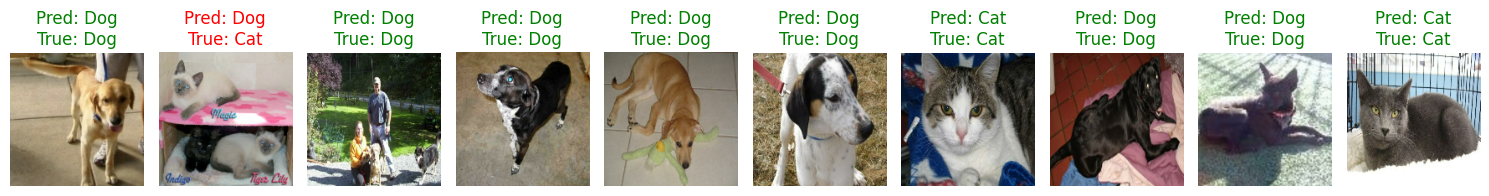

In [17]:
# Visualize some predictions
def plot_predictions(dataset, num_images=5):
    # Get a batch of images
    images, labels = next(iter(dataset.unbatch().batch(num_images)))
    
    # Make predictions
    predictions = model.predict(images)
    
    # Plot the images and predictions
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        pred_label = "Dog" if predictions[i] > 0.5 else "Cat"
        true_label = "Dog" if labels[i] == 1 else "Cat"
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on validation dataset
print("Sample predictions on validation dataset:")
plot_predictions(validation_ds, 10)